# Demonstrating the use of simple collaborative filtering algorithms on small data set which contains ratings for musical instruments.

In [1]:
import numpy as np
import pandas as pd

In [2]:
df=pd.read_csv('ratings_Musical_Instruments.csv',header=None, nrows=12000)
df.head() #column order: user, items, ratings, timestamp

,0,1,2,3
0,A1YS9MDZP93857,0006428320,3.0,1394496000
1,A3TS466QBAWB9D,0014072149,5.0,1370476800
2,A3BUDYITWUSIS7,0041291905,5.0,1381708800
3,A19K10Z0D2NTZK,0041913574,5.0,1285200000
4,A14X336IB4JD89,0201891859,1.0,1350432000


In [3]:
df.shape

(12000, 4)

In [4]:
n_users = df[0].unique().shape[0]
n_items = df[1].unique().shape[0]
n_rating = df[2].unique().shape[0]

print ('%i unique users' %n_users)
print ('%i unique items' %n_items)
print ('%i unique ratings' %n_rating)

10491 unique users
3183 unique items
5 unique ratings


In [5]:
#generate user-item matrix
ratings=df.pivot(index=0, columns=1, values=2)

In [6]:
ratings=ratings.fillna(0).as_matrix()

In [7]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print ('percentage of user-items that have a rating: {:.2f}%'.format(sparsity))

percentage of user-items that have a rating: 0.04%


In [8]:
# This creats a validation dataset by selecting rows (user) that have 35 or more ratings, then randomly select 15 of those ratings
#for validation set, but set those values to 0 in the training set.

def train_test_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy() #don't do train=ratings, other wise, ratings becomes empty
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0])>=35:# 35 seems to be best, it depends on sparsity of your user-item matrix
            val_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=15, #tweak this, 15 seems to be optimal
                                        replace=False)
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    print(validation.shape)
    return train, validation

In [9]:
train, val = train_test_split(ratings)

(10491, 3183)


In [10]:
from numpy import linalg as LA

In [11]:
def cos_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
        norms=np.array(LA.norm(ratings)*LA.norm(ratings.T))
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
        norms = np.array(LA.norm(ratings.T)*LA.norm(ratings))
    return (sim / norms )

In [12]:
user_similarity = cos_similarity(train, kind='user')
item_similarity=cos_similarity(train, kind='item')
#print (user_similarity[-10:, 10:])
#print (item_similarity[-10:, 10:])

# Generate prediction using cosine similarity matrix as weights (memory based) and adjusting bias for individual user by mean-subtraction of rating

In [13]:
def predict_nobias(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += item_bias[np.newaxis, :]
        
    return pred

In [14]:
user_prediction2 = predict_nobias(train, user_similarity, kind='user')
item_prediction2 = predict_nobias(train, item_similarity, kind='item')

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [23]:
print ('User-based bias-adjusted CF RMSE: %.2f' %rmse(user_prediction2, val))
print ('Item-based bias-adjusted CF RMSE: %.2f' %rmse(item_prediction2, val))

User-based bias-adjusted CF RMSE: 4.54
Item-based bias-adjusted CF RMSE: 4.43


# Model based collaborative filtering - matrix factorization (via SVD)

In [19]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [26]:
#get SVD components from train matrix. Choose k.
u, s, vt = svds(train, k = 20)#tweak k, dimensionality for rank matrix
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

In [27]:
print ('matrix-factorization CF RMSE: %.2f' %rmse(X_pred, val))


matrix-factorization CF RMSE: 4.47


# Using Stochastic Gradient Descend method to update the above low rank matrices for the latent features (online learning). 

In [28]:
#P is latent user feature matrix
#Q is latent item feature matrix
def prediction(P,Q):
    return np.dot(P.T,Q)

In [46]:
lmbda = 0.4 # Regularization parameter
k = 3 #tweak this parameter
m, n = train.shape  # Number of users and items
n_epochs = 100  # Number of epochs
alpha=0.01  # Learning rate

P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix

In [47]:
train_errors = []
val_errors = []

#Only consider items with ratings 
users,items = train.nonzero()      
for epoch in range(n_epochs):
    for u, i in zip(users,items):
        e = train[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient update
        P[:,u] += alpha * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
        Q[:,i] += alpha * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent item feature matrix
    
    train_rmse = rmse(prediction(P,Q),train)
    val_rmse = rmse(prediction(P,Q),val) 
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)

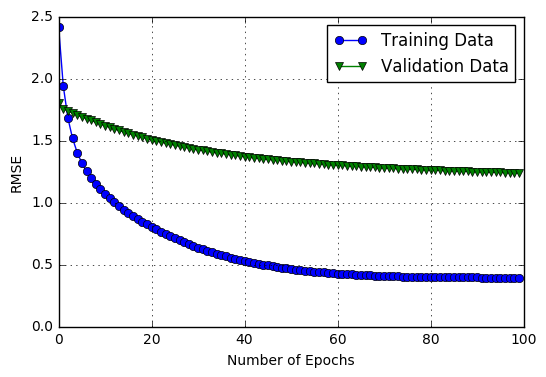

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), val_errors, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

# Take a look at prediction vs. actual ratings

In [49]:
SGD_prediction=prediction(P,Q)

In [50]:
estimation= SGD_prediction[val.nonzero()]
ground_truth = val[val.nonzero()]
results=pd.DataFrame({'prediction':estimation, 'actual rating':ground_truth})

In [52]:
results.head()

,actual rating,prediction
0,5.0,5.000190
1,5.0,4.225069
2,5.0,4.426674
3,4.0,4.370660
4,5.0,3.675630
